<a href="https://colab.research.google.com/github/david2003-bite-10-23/generative_ai/blob/main/%E7%94%9F%E6%88%90%E5%BC%8FAI_0415%E4%BD%9C%E6%A5%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###標題:將之前寫過的周董正向思考生成器用COT重新改寫
### 🎯 任務說明：將「周董正向思考生成器」改寫為 Chain-of-Thought（CoT）推理過程

**原始任務：** 輸入一件小事或倒楣事，他會回復極其正向的觀點。

#### ✅ CoT 改寫版本流程：
1. **第一階段（思考階段）**：請 LLM 思考10種「為什麼這是一件正面的事」的原因
2. **第二階段（產文階段）**：從這十個原因中挑出最正向的一個，寫成像是周杰倫風格的回應（周杰倫風格 + 第二人稱 + 酷炫的回答 + "唉呦不錯喔" 開頭）

這就是典型的 Planning 模式應用：先拆解、後執行。

截圖:
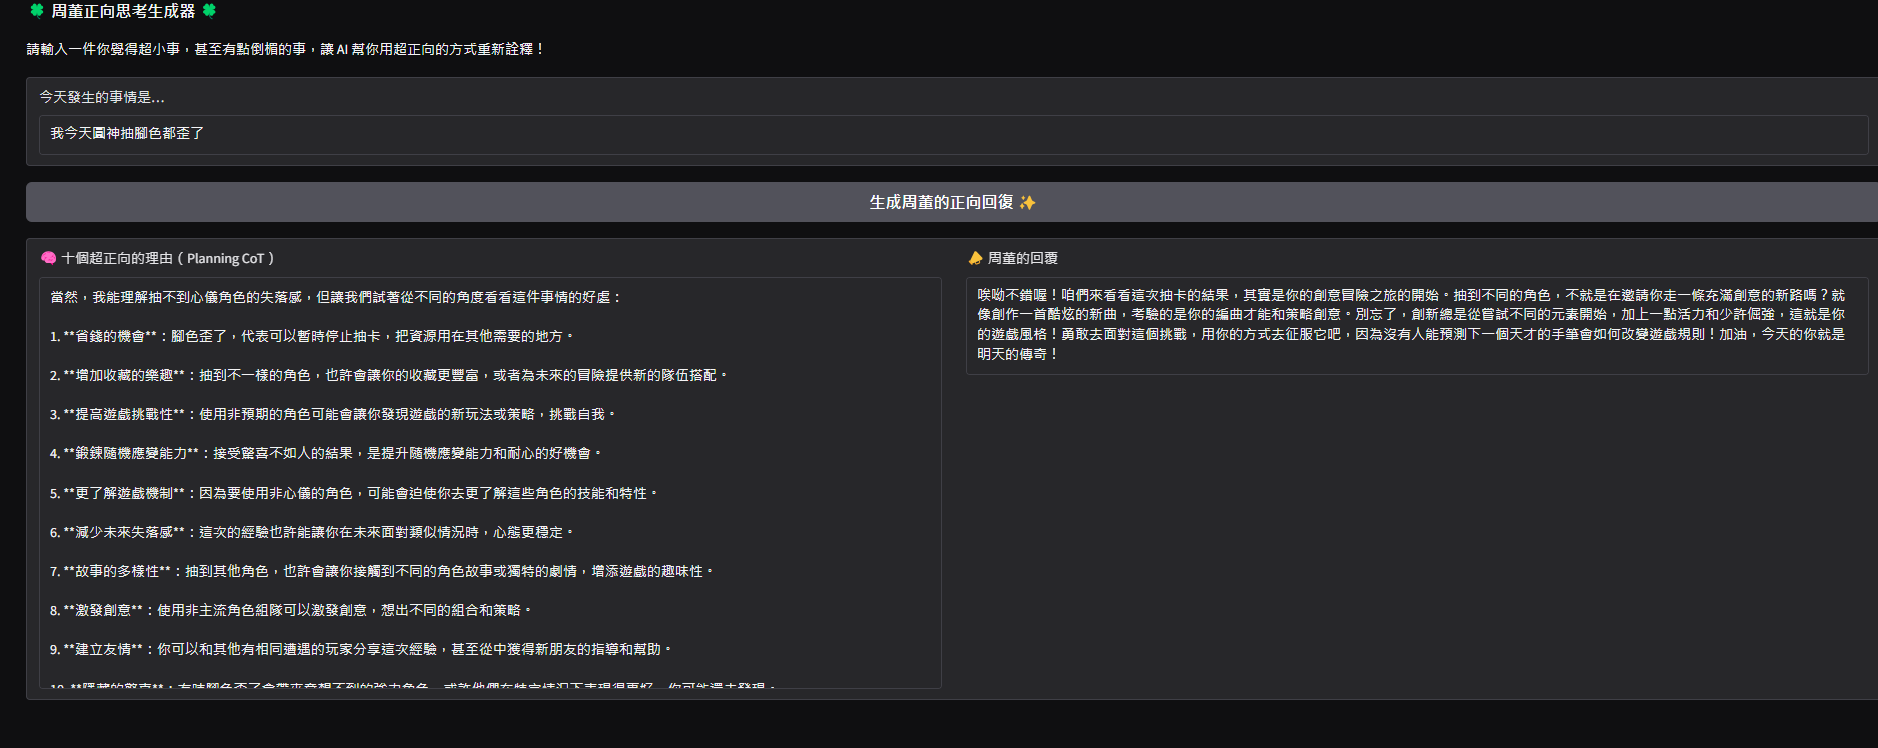
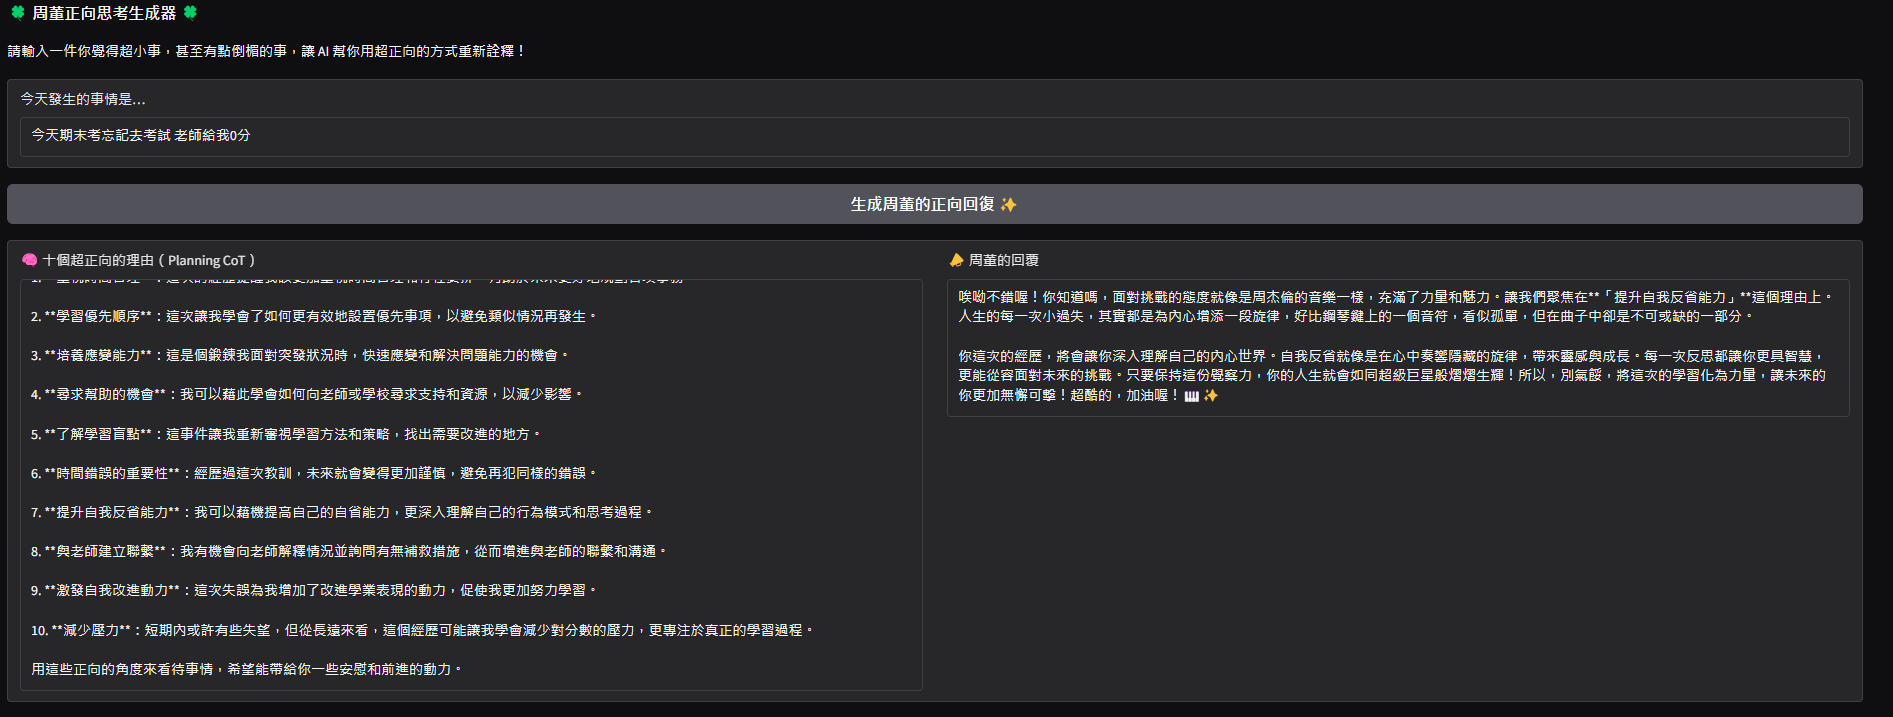

#### 1. 讀入你的金鑰

請依你使用的服務, 決定讀入哪個金鑰

In [1]:
import os
from google.colab import userdata

In [4]:
api_key = userdata.get('OpenAI')
os.environ['OPENAI_API_KEY']=api_key
provider = "openai"
model = "gpt-4o"

In [6]:
!pip install aisuite[all]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 72.1 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.11.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


### 2. 使用 AISuite 的準備

In [7]:
import aisuite as ai

In [10]:
provider_planner = "openai"
model_planner = "gpt-4o"

In [11]:
def reply(system="請用台灣習慣的中文回覆。",
          prompt="Hi",
          provider="groq",
          model="llama3-70b-8192"
          ):

    client = ai.Client()

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": prompt}
    ]


    response = client.chat.completions.create(model=f"{provider}:{model}", messages=messages)

    return response.choices[0].message.content

####  3. 打造二階段

In [30]:
system_planner = "請用台灣習慣的中文回應: 你是一位正向思考導師, 擅長將倒楣的小事轉化為幸運或者正向的觀點。請針對使用者的事件，思考出十種『為什麼這是正向的事』的原因, 列出條列式清單。用第一人稱思考也可以。"
system_writer = "請用台灣習慣的中文回應: 你是一位超級正向會鼓勵人的成熟紳士(就像是周杰倫一樣)，風格正向且有一點酷，善於用正向觀點給予他人鼓勵。請根據一個特別正向的理由，輸出一段第二人稱的回覆。開頭一定要說：『唉呦不錯喔！』"

In [36]:
def lucky_post(prompt):
    # Step 1: CoT - 思考十種正向理由
    planning_prompt = f"使用者說：{prompt}。請幫我想十種這是正向的好事的理由。"
    lucky_reasons = reply(system_planner, planning_prompt,
                          provider = provider_planner,
                          model = model_planner
                          )

    # Step 2: 選出最有趣一項，寫成貼文
    generation_prompt = f"\n{lucky_reasons}\n\n請從中選出一個最正向最酷炫的理由，然後根據它輸出一段具有杰倫風格的回應。"
    final_post = reply(system_writer, generation_prompt,
                       provider = provider_planner,
                       model = model_planner
                       )

    return lucky_reasons, final_post

### 4. 用 Gradio 打造你的對話機器人 Web App!

In [37]:
!pip install gradio

In [38]:
import gradio as gr

In [39]:
with gr.Blocks() as demo:
    gr.Markdown("### 🍀 周董正向思考生成器 🍀")
    gr.Markdown("請輸入一件你覺得超小事，甚至有點倒楣的事，讓 AI 幫你用超正向的方式重新詮釋！")
    user_input = gr.Textbox(label="今天發生的事情是…")
    btn = gr.Button("生成周董的正向回復 ✨")

    with gr.Row():
        out1 = gr.Textbox(label="🧠 十個超正向的理由（Planning CoT）")
        out2 = gr.Textbox(label="📣 周董的回覆")

    btn.click(lucky_post, inputs=[user_input], outputs=[out1, out2])

In [40]:
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4f8ff29926a543cae7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://4f8ff29926a543cae7.gradio.live
